In [2]:

import argparse
import random,os
import numpy as np
import argparse
import torch
from tqdm import tqdm
import scanpy as sc
import torch.nn.functional as F
from model.load import *

In [3]:
#Set random seed
random.seed(0)
np.random.seed(0)  # numpy random generator

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
device = torch.device('cuda:0')

In [4]:
# define data path
data_path = './examples/cluster_19264.h5ad'

# load model
ckpt_path = './model/models/models.ckpt'
pretrainmodel,pretrainconfig = load_model_frommmf(ckpt_path, 'm1', device=device)
pretrainmodel.eval()

{'mask_gene_name': False, 'gene_num': 19266, 'seq_len': 19266, 'encoder': {'hidden_dim': 768, 'depth': 12, 'heads': 12, 'dim_head': 64, 'seq_len': 19266, 'module_type': 'transformer', 'norm_first': False}, 'decoder': {'hidden_dim': 512, 'depth': 6, 'heads': 8, 'dim_head': 64, 'module_type': 'performer', 'seq_len': 19266, 'norm_first': False}, 'n_class': 104, 'pad_token_id': 103, 'mask_token_id': 102, 'bin_num': 100, 'bin_alpha': 1.0, 'rawcount': True, 'model': 'mae_autobin', 'test_valid_train_idx_dict': '/nfs_beijing/minsheng/data/os10000w-new/global_shuffle/meta.csv.train_set_idx_dict.pt', 'valid_data_path': '/nfs_beijing/minsheng/data/valid_count_10w.npz', 'num_tokens': 13, 'train_data_path': None, 'isPanA': False, 'isPlanA1': False, 'max_files_to_load': 5, 'bin_type': 'auto_bin', 'value_mask_prob': 0.3, 'zero_mask_prob': 0.03, 'replace_prob': 0.8, 'random_token_prob': 0.1, 'mask_ignore_token_ids': [0], 'decoder_add_zero': True, 'mae_encoder_max_seq_len': 15000, 'isPlanA': False, 'ma

Model(
  (token_emb): AutoDiscretizationEmbedding2(
    (mlp): Linear(in_features=1, out_features=100, bias=True)
    (mlp2): Linear(in_features=100, out_features=100, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.1)
    (Softmax): Softmax(dim=-1)
    (emb): Embedding(100, 768)
    (emb_mask): Embedding(1, 768)
    (emb_pad): Embedding(1, 768)
  )
  (pos_emb): Embedding(19267, 768)
  (cell_vq): SoftCVQLayer(
    (embedding_mlp): Sequential(
      (0): Linear(in_features=12, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=1024, bias=True)
      (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear

In [8]:
# inference

def get_cellemb(geneemb, pool_type='max'):
    geneemb1 = geneemb[:,-1,:]
    geneemb2 = geneemb[:,-2,:]
    geneemb3, _ = torch.max(geneemb[:,:-2,:], dim=1)
    geneemb4 = torch.mean(geneemb[:,:-2,:], dim=1)
    if pool_type=='all':
        geneembmerge = torch.concat([geneemb1,geneemb2,geneemb3,geneemb4],axis=1)
    elif pool_type=='max':
        geneembmerge, _ = torch.max(geneemb, dim=1)
    else:
        raise ValueError('pool_type must be all or max')
    return geneembmerge

gexpr_feature = sc.read(data_path).X.toarray() if data_path.endswith('.h5ad') else np.load(data_path)
cellembs=[]
cell_codes = []
for i in tqdm(range(gexpr_feature.shape[0])):
    with torch.no_grad():
        # pre-Normalization
        tmpdata = (np.log1p(gexpr_feature[i,:]/(gexpr_feature[i,:].sum())*1e4)).tolist()
        totalcount = gexpr_feature[i,:].sum()
        pretrain_gene_x = torch.tensor(tmpdata+[np.log10(totalcount),np.log10(totalcount)]).unsqueeze(0).to(device)

        encoder_data, encoder_position_gene_ids, encoder_data_padding, encoder_labels, decoder_data, decoder_data_padding, new_data_raw, data_mask_labels, decoder_position_gene_ids = getEncoerDecoderData(pretrain_gene_x.float(),pretrain_gene_x.float(),pretrainconfig)
        x, cell_code, _ = pretrainmodel.get_cellcode(x=encoder_data, 
                                        padding_label=encoder_data_padding, 
                                        encoder_position_gene_ids=encoder_position_gene_ids, 
                                        output_attentions=False)
        cellembs.append(get_cellemb(x, pool_type='all').detach().cpu().numpy())
        cell_codes.append(cell_code.detach().cpu().numpy())
cellembs = np.squeeze(np.array(cellembs))
cell_codes = np.squeeze(np.array(cell_codes))

/root/anaconda3/envs/flash/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
  0%|          | 0/10000 [00:00<?, ?it/s]/root/anaconda3/envs/flash/lib/python3.9/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
100%|██████████| 10000/10000 [04:42<00:00, 35.43it/s]


In [9]:
cellembs

array([[-1.7134088 ,  0.9817577 , -1.626916  , ..., -1.8094808 ,
        -0.41371393,  0.6537805 ],
       [-1.0709275 ,  2.3766146 , -1.2158602 , ..., -1.6377342 ,
        -0.9149187 ,  0.3691712 ],
       [-3.0749688 ,  1.0160341 ,  0.368997  , ..., -1.2800682 ,
        -1.0066636 ,  0.3342606 ],
       ...,
       [-2.531473  ,  1.953028  , -0.624969  , ..., -0.18196258,
        -1.393032  ,  1.840565  ],
       [-3.140465  ,  1.328505  , -2.4485662 , ..., -0.6321247 ,
        -0.9012232 , -1.053768  ],
       [-0.673172  ,  0.4283453 , -2.2405875 , ..., -2.0441573 ,
         0.24671729, -1.1006567 ]], dtype=float32)

In [9]:
cell_codes

array([3049, 2821, 2349, ..., 4020, 1818, 1433])

In [14]:
# load pancreas test data
data_path = '/guoxiaopeng/wangjue/data/celldata/scGPT/data/cellxgene/test_data/pancreas_sub.h5ad'
data0 = sc.read(data_path)
cell_uni = data0.obs['cell_type'].unique().tolist()
cell_type_int = np.array([cell_uni.index(item) for item in data0.obs['cell_type']])
cluster_num = 11
print(cluster_num)

11


/root/anaconda3/envs/flash/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [15]:
# perform clustering task on pancreas data

from sklearn.cluster import KMeans
import numpy as np
from sklearn import metrics
from sklearn.metrics import silhouette_score

def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    ind = np.array(list(zip(row_ind, col_ind)))
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

def cal_cluster_metrics(y, y_pred, X):
    acc = np.round(cluster_acc(y, y_pred), 5)
    y = list(map(int, y))
    y_pred = np.array(y_pred)
    nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
    sil = silhouette_score(X, np.array(y))
    return acc, nmi, ari, sil

kmeans = KMeans(cluster_num)
kmeans.fit(cellembs)
acc1, nmi1, ari1, sil1 = cal_cluster_metrics(cell_type_int, kmeans.labels_, cellembs)
print(acc1, nmi1, ari1, sil1)

0.9412 0.93424 0.94359 0.4601455


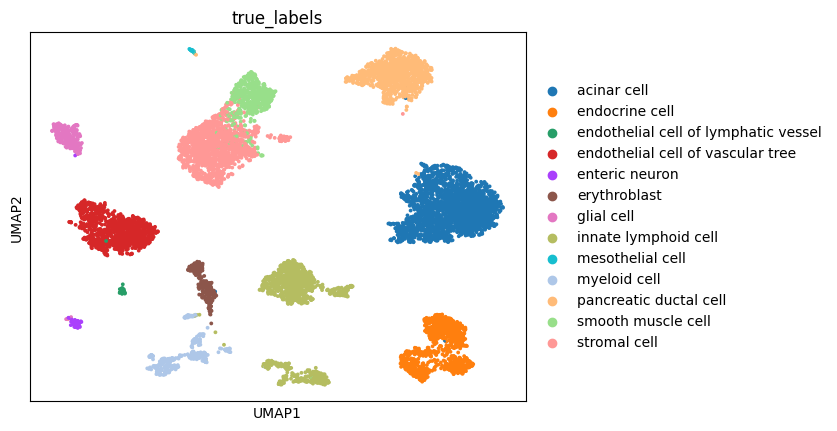

In [ ]:
# UMAP visulization on pancreas data
sc_data = sc.AnnData(cellembs)
sc.pp.neighbors(sc_data, use_rep='X', random_state=0)
sc.tl.umap(sc_data)
sc_data.obs['true_labels'] = data0.obs['cell_type'].tolist()
sc.pl.umap(sc_data,color=['true_labels'],wspace=0.3,size=30,save='pancreas', frameon=True)

In [22]:
# define data path
data_path = '/guoxiaopeng/wangjue/data/celldata/chriscell_data/cell_type_rawdata/Segerstolpe/data-test-count.npy'

# load model
ckpt_path = './model/models/models.ckpt'
pretrainmodel,pretrainconfig = load_model_frommmf(ckpt_path, 'm2', device=device)
pretrainmodel.eval()

{'mask_gene_name': False, 'gene_num': 19266, 'seq_len': 19266, 'encoder': {'hidden_dim': 768, 'depth': 12, 'heads': 12, 'dim_head': 64, 'seq_len': 19266, 'module_type': 'transformer', 'norm_first': False}, 'decoder': {'hidden_dim': 512, 'depth': 6, 'heads': 8, 'dim_head': 64, 'module_type': 'performer', 'seq_len': 19266, 'norm_first': False}, 'n_class': 104, 'pad_token_id': 103, 'mask_token_id': 102, 'bin_num': 100, 'bin_alpha': 1.0, 'rawcount': True, 'model': 'mae_autobin', 'test_valid_train_idx_dict': '/nfs_beijing/minsheng/data/os10000w-new/global_shuffle/meta.csv.train_set_idx_dict.pt', 'valid_data_path': '/nfs_beijing/minsheng/data/valid_count_10w.npz', 'num_tokens': 13, 'train_data_path': None, 'isPanA': False, 'isPlanA1': False, 'max_files_to_load': 5, 'bin_type': 'auto_bin', 'value_mask_prob': 0.3, 'zero_mask_prob': 0.03, 'replace_prob': 0.8, 'random_token_prob': 0.1, 'mask_ignore_token_ids': [0], 'decoder_add_zero': True, 'mae_encoder_max_seq_len': 15000, 'isPlanA': False, 'ma

Model(
  (token_emb): AutoDiscretizationEmbedding2(
    (mlp): Linear(in_features=1, out_features=100, bias=True)
    (mlp2): Linear(in_features=100, out_features=100, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.1)
    (Softmax): Softmax(dim=-1)
    (emb): Embedding(100, 768)
    (emb_mask): Embedding(1, 768)
    (emb_pad): Embedding(1, 768)
  )
  (pos_emb): Embedding(19267, 768)
  (cell_vq): SoftCVQLayer(
    (embedding_mlp): Sequential(
      (0): Linear(in_features=12, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=1024, bias=True)
      (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear

In [23]:
# inference

def get_cellemb(geneemb, pool_type='max'):
    geneemb1 = geneemb[:,-1,:]
    geneemb2 = geneemb[:,-2,:]
    geneemb3, _ = torch.max(geneemb[:,:-2,:], dim=1)
    geneemb4 = torch.mean(geneemb[:,:-2,:], dim=1)
    if pool_type=='all':
        geneembmerge = torch.concat([geneemb1,geneemb2,geneemb3,geneemb4],axis=1)
    elif pool_type=='max':
        geneembmerge, _ = torch.max(geneemb, dim=1)
    else:
        raise ValueError('pool_type must be all or max')
    return geneembmerge

gexpr_feature = sc.read(data_path).X.toarray() if data_path.endswith('.h5ad') else np.load(data_path)
cellembs=[]
cell_codes = []
for i in tqdm(range(gexpr_feature.shape[0])):
    with torch.no_grad():
        # pre-Normalization
        tmpdata = (np.log1p(gexpr_feature[i,:]/(gexpr_feature[i,:].sum())*1e4)).tolist()
        totalcount = gexpr_feature[i,:].sum()
        pretrain_gene_x = torch.tensor(tmpdata+[4.0,np.log10(totalcount)]).unsqueeze(0).to(device)

        encoder_data, encoder_position_gene_ids, encoder_data_padding, encoder_labels, decoder_data, decoder_data_padding, new_data_raw, data_mask_labels, decoder_position_gene_ids = getEncoerDecoderData(pretrain_gene_x.float(),pretrain_gene_x.float(),pretrainconfig)
        x, cell_code, _ = pretrainmodel.get_vqcode(x=encoder_data, 
                                        padding_label=encoder_data_padding, 
                                        encoder_position_gene_ids=encoder_position_gene_ids, 
                                        output_attentions=False)
        cellembs.append(get_cellemb(x, pool_type='all').detach().cpu().numpy())
        cell_codes.append(cell_code.detach().cpu().numpy())
cellembs = np.squeeze(np.array(cellembs))
cell_codes = np.squeeze(np.array(cell_codes))

  0%|          | 0/427 [00:00<?, ?it/s]/root/anaconda3/envs/flash/lib/python3.9/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
100%|██████████| 427/427 [02:08<00:00,  3.32it/s]


In [29]:
# load Segerstolpe test data
cell_type_int = np.load('/guoxiaopeng/wangjue/data/celldata/chriscell_data/cell_type_rawdata/Segerstolpe/Segerstolpe-test-label.npy')
cluster_num = len(np.unique(cell_type_int)) - 1
print(cluster_num)

12


In [30]:
kmeans = KMeans(cluster_num)
kmeans.fit(cellembs)
acc1, nmi1, ari1, sil1 = cal_cluster_metrics(cell_type_int, kmeans.labels_, cellembs)
print(acc1, nmi1, ari1, sil1)

0.79625 0.88548 0.71588 0.62934434


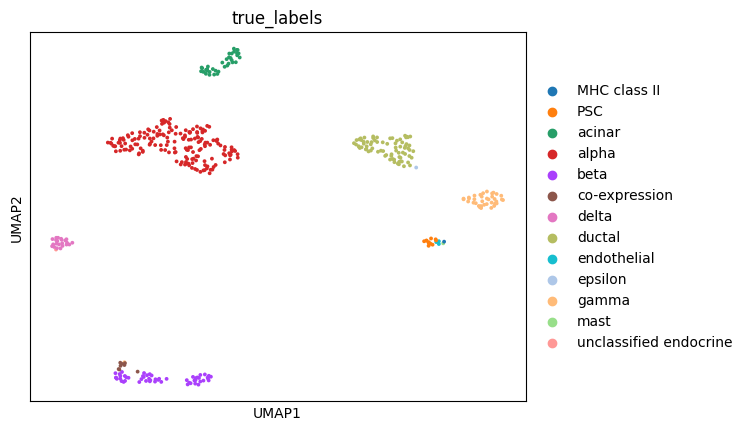

In [31]:
# UMAP visulization on Segerstolpe data
cell_type_str = np.load('/guoxiaopeng/wangjue/data/celldata/chriscell_data/cell_type_rawdata/Segerstolpe/Segerstolpe-str_label.npy')
sc_data = sc.AnnData(cellembs)
sc.pp.neighbors(sc_data, use_rep='X', random_state=0)
sc.tl.umap(sc_data)
sc_data.obs['true_labels'] = [cell_type_str[i] for i in cell_type_int]
sc.pl.umap(sc_data,color=['true_labels'],wspace=0.3,size=30,save='Segerstolpe', frameon=True)